In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

/home/users/westentp/anaconda3/envs/orca/lib/python3.7/site-packages/bs4/__init__.py:408: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


In [50]:
res_dict = {"½-½": 0.5, "1-0": 1, "0-1": 0}

In [34]:
def is_elo(td):
    try:
        val = int(td.text)
    except:
        return False
    return 700 < val < 3000

In [51]:
def is_result(td):
    return td.text.replace(" ", "") in res_dict

In [47]:
def is_result_row(tr):
    tds = tr.find_all("td")
    if not len(tds) == 15:
        return False
    return is_elo(tds[5]) and is_elo(tds[11]) and is_result(tds[7])

In [48]:
results = [tr for tr in soup.find_all("tr") if is_result_row(tr)]

In [63]:
def extract_info(resultrow):
    tds = resultrow.find_all("td")
    elo_white = int(tds[5].text)
    elo_black = int(tds[11].text)
    res = res_dict[tds[7].text.replace(" ", "")]
    elo_diff = elo_white - elo_black
    fav = elo_diff >= 0
    if fav:
        res_fav = res
    else:
        res_fav = 1 - res
    return abs(elo_diff), res_fav

In [66]:
def get_fav_res_df(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    results = [tr for tr in soup.find_all("tr") if is_result_row(tr)]
    return pd.DataFrame([extract_info(rr) for rr in results])
    

In [67]:
all_res_df = []
for rd in range(1, 8):
    url = f"https://chess-results.com/tnr788407.aspx?lan=1&art=2&rd={rd}&fed=MEX&turdet=YES&flag=30&zeilen=99999"
    df = get_fav_res_df(url)
    all_res_df.append(df)



In [97]:
for rd in range(1, 9):
    url = f"https://chess-results.com/tnr649615.aspx?lan=1&art=2&rd={rd}&turdet=YES&flag=30&zeilen=99999"
    df = get_fav_res_df(url)
    all_res_df.append(df)


In [98]:
df = pd.concat(all_res_df)

In [99]:
df.columns = ["elo_diff", "result"]

In [100]:
df['elo_diff_rounded'] = (df["elo_diff"] / 20).round() * 20

In [101]:
def elo_exp(diff):
    return 1/(1+10**(-diff/400))

In [102]:
df["expect"] = df['elo_diff_rounded'].apply(elo_exp)

In [103]:
df["count"] = 1

<AxesSubplot:xlabel='elo_diff_rounded'>

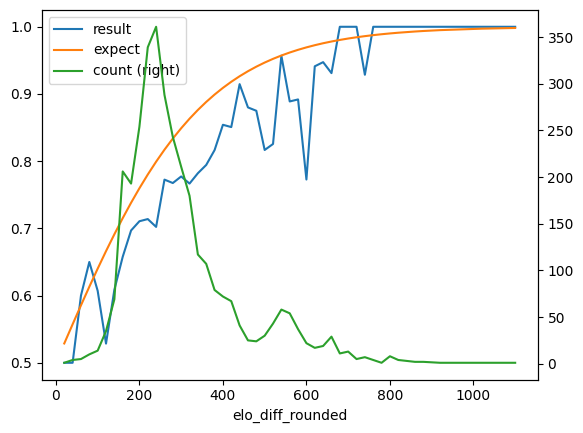

In [104]:
df.groupby("elo_diff_rounded", as_index=False).agg({"result": "mean", "expect": "mean", "count": "sum"}).plot(x="elo_diff_rounded", y=["result", "expect", "count"], secondary_y="count")

In [111]:
df["elo_400_cap"] = df["elo_diff_rounded"].apply(lambda x: min([x, 400]))

<AxesSubplot:xlabel='elo_400_cap'>

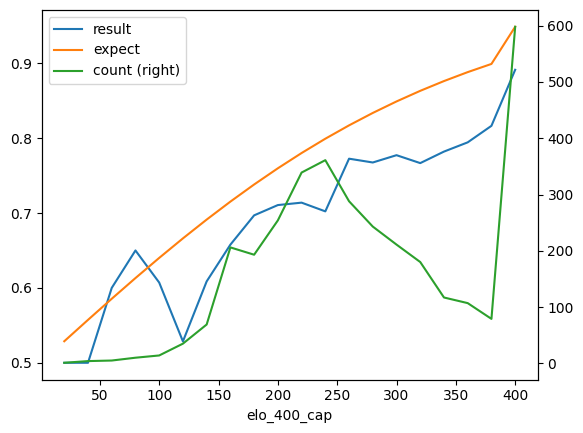

In [112]:
df.groupby("elo_400_cap", as_index=False).agg({"result": "mean", "expect": "mean", "count": "sum"}).plot(x="elo_400_cap", y=["result", "expect", "count"], secondary_y="count")

In [110]:
df

,elo_diff,result,elo_diff_rounded,expect,count,elo_400_cap
0,803,1.0,800.0,0.990099,1,400
1,796,1.0,800.0,0.990099,1,400
2,799,1.0,800.0,0.990099,1,400
3,733,1.0,740.0,0.986071,1,400
4,735,1.0,740.0,0.986071,1,400
...,...,...,...,...,...,...
209,392,0.0,400.0,0.909091,1,392
210,401,1.0,400.0,0.909091,1,400
211,403,1.0,400.0,0.909091,1,400
212,175,1.0,180.0,0.738109,1,175


In [105]:
df.shape

(3314, 5)

In [107]:
df.groupby("elo_diff_rounded", as_index=False).agg({"result": "mean", "expect": "mean", "count": "sum"})

,elo_diff_rounded,result,expect,count
0,20.0,0.500000,0.528751,1
1,40.0,0.500000,0.557312,4
2,60.0,0.600000,0.585499,5
3,80.0,0.650000,0.613137,10
4,100.0,0.607143,0.640065,14
5,120.0,0.528571,0.666139,35
6,140.0,0.608696,0.691236,69
7,160.0,0.657767,0.715253,206
8,180.0,0.696891,0.738109,193
9,200.0,0.710630,0.759747,254


In [45]:
soup.find_all("tr")[101].find_all("td")[7]


<td class="CRc">1 - 0</td>

In [46]:
is_result_row(soup.find_all("tr")[101])

False

In [14]:
for tr in soup.find_all("tr"):
    print(len(str(tr)))

876
268
21
273
4129
1390
33
178813
178693
7175
104
72
99
109
376
89
67
76
104
178
77
61
317
970
327
527
290
1000
870
204
320
487
378
727
725
729
726
725
717
724
724
715
720
641
637
640
639
651
638
640
645
640
641
635
646
646
645
646
656
632
644
651
638
649
637
640
639
629
637
636
652
637
637
662
636
635
648
650
656
659
651
641
645
638
639
649
659
644
644
637
639
635
644
643
640
642
647
649
647
651
645
642
650
643
646
653
636
651
640
652
640
642
643
644
654
648
644
642
636
649
647
635
638
647
646
646
652
652
647
646
662
651
655
643
639
658
643
640
657
661
650
646
647
656
639
661
648
655
645
648
664
652
650
651
646
646
648
649
657
640
648
647
647
643
649
647
647
643
643
649
650
647
660
649
648
652
655
652
651
645
662
648
646
647
652
655
641
645
659
643
644
644
654
650
643
647
645
655
648
650
646
661
651
650
651
646
640
647
649
640
646
642
655
657
649
648
643
647
648
649
647
647
647
641
652
650
650
655
650
653
646
647
643
649
643
644
649
641
651
642
644
654
651
635
651
650
660
646
649
638

In [7]:
soup.prettify()

'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml">\n <head id="Head1">\n  <script async="" src="https://cdn.fuseplatform.net/publift/tags/2/3060/fuse.js">\n  </script>\n  <script type="text/javascript">\n   const fusetag = window.fusetag || (window.fusetag = { que: [] });\r\n\r\n  fusetag.que.push(function () {\r\n    fusetag.pageInit();\r\n    fusetag.registerAll();\r\n   });\n  </script>\n  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>\n  <meta content="Chess-Results.com is a powerful and dedicated server only for chess-results. The tournament archive of chess-results.com contains more than 40.000 tournaments from around the world." name="description"/>\n  <meta content="Chess tournament, Chess, Herzog, Heinz, Heinz Herzog, Swiss-Manager, Chesspairing, chess results, chess championship, European chess championship, FIDE, Chess International, ches